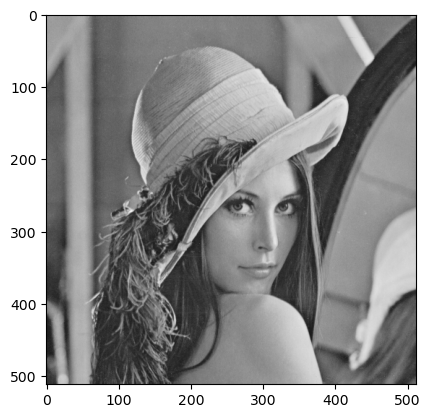

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

image = cv2.imread('lena.bmp')
plt.imshow(image)
plt.show()

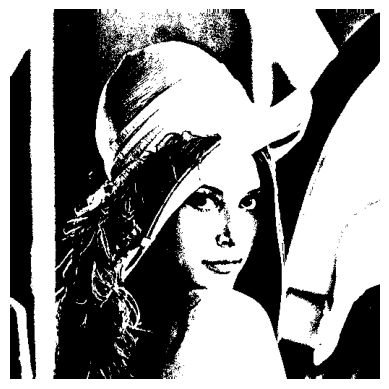

In [2]:
image = cv2.imread('lena.bmp', cv2.IMREAD_GRAYSCALE) 
threshold = 128
binary_image = np.zeros_like(image, dtype=np.uint8)
height, width = image.shape

# Thresholding
for y in range(height):
    for x in range(width):
        if image[y, x] >= threshold:
            binary_image[y, x] = 255  
            
plt.axis('off')
plt.imshow(binary_image, cmap='gray') 
cv2.imwrite('1a.bmp', binary_image) 
binary = binary_image #for (c)

In [3]:
from PIL import Image

image_path = 'lena.bmp'
image = Image.open(image_path).convert('L') 

pixels = list(image.getdata())

hist = [0] * 256
for pixel in pixels:
    hist[pixel] += 1
    
print(hist)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 7, 19, 29, 59, 97, 137, 182, 221, 299, 422, 499, 614, 758, 944, 1060, 1255, 1441, 1648, 1760, 1884, 1998, 2090, 2023, 2101, 2088, 2030, 1978, 1808, 1730, 1668, 1577, 1469, 1278, 1236, 1220, 1003, 930, 975, 880, 893, 789, 798, 769, 782, 850, 821, 831, 785, 883, 906, 867, 854, 947, 973, 906, 912, 867, 934, 933, 970, 1005, 1019, 1060, 1133, 1125, 1186, 1219, 1324, 1400, 1538, 1619, 1807, 1871, 2085, 1895, 1935, 1958, 1831, 1761, 1729, 1614, 1504, 1437, 1363, 1362, 1347, 1345, 1448, 1362, 1352, 1388, 1450, 1561, 1575, 1604, 1781, 1813, 1893, 2037, 2137, 2304, 2319, 2373, 2519, 2305, 2302, 2252, 2076, 1995, 1818, 1935, 1903, 2025, 2140, 2258, 2305, 2324, 2455, 2458, 2409, 2234, 2315, 2288, 2182, 2275, 2315, 2391, 2598, 2685, 2742, 2701, 2556, 2410, 2261, 2041, 1853, 1781, 1613, 1473, 1425, 1353, 1233, 1254, 1195, 1171, 1208, 1344, 1265, 1230, 1158, 1185, 1227, 1086, 942, 904, 822, 784, 689, 610, 628, 644, 679, 63

In [2]:
plt.figure(figsize=(10, 5))
plt.plot(hist, color='black')
plt.title('Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('1b.png', bbox_inches='tight', pad_inches=0)
plt.show()

NameError: name 'plt' is not defined

In [5]:
#前處理
lena = Image.open('lena.bmp').convert('L')  
lena_arr = np.array(lena)
threshold = 128
binary_image = (lena_arr >= threshold).astype(int) #trasfer to 01
height, width = binary_image.shape
mark = 2 
bounding_boxes = {}  

#find connecting components
for y in range(height):
    for x in range(width):
        if binary_image[y, x] == 1:
            top_label = binary_image[y-1, x] if y > 0 else 0
            left_label = binary_image[y, x-1] if x > 0 else 0

            if top_label > 1 and left_label > 1: #if both marked, merge two components
                if top_label != left_label:
                    min_label = min(top_label, left_label)
                    max_label = max(top_label, left_label)

                    # merge
                    binary_image[binary_image == max_label] = min_label
                    min_box = bounding_boxes[min_label]
                    max_box = bounding_boxes[max_label]
                    bounding_boxes[min_label] = (
                        min(min_box[0], max_box[0]),  # Top
                        max(min_box[1], max_box[1]),  # Bottom
                        min(min_box[2], max_box[2]),  # Left
                        max(min_box[3], max_box[3]),  # Right
                        min_box[4] + max_box[4],      # 面積
                        min_box[5] + max_box[5],      # x權重
                        min_box[6] + max_box[6]       # y權重
                    )
                    del bounding_boxes[max_label]
                    
                binary_image[y, x] = min(top_label, left_label) #避免遍歷時未合併完全
                label = binary_image[y, x]
            elif top_label > 1:
                binary_image[y, x] = top_label
                label = top_label
            elif left_label > 1:
                binary_image[y, x] = left_label
                label = left_label
            else:
                binary_image[y, x] = mark
                bounding_boxes[mark] = (y, y, x, x, 1, x, y)  # (top, bottom, left, right, 面積, x權重, y權重)
                mark += 1
                label = binary_image[y, x]
                
            #Reset component information
            top, bottom, left, right, area, sum_x, sum_y = bounding_boxes[label]
            bounding_boxes[label] = (
                min(top, y), max(bottom, y), min(left, x), max(right, x), area + 1,
                sum_x + x, sum_y + y 
            )

# Calculate centroids
for label in bounding_boxes.keys():
    bbox = bounding_boxes[label]
    if bbox[4] > 0:
        centroid_x = bbox[5] // bbox[4] #sum_x/area
        centroid_y = bbox[6] // bbox[4] #sum_y/area
        bounding_boxes[label] = (*bbox[:4], bbox[4], centroid_x, centroid_y)

In [6]:
HW2c=np.array([[[i]*3 for i in j] for j in binary],dtype='uint8') #turn result in (a) to 512,512,3
for label in bounding_boxes.keys():
    bbox = bounding_boxes[label]
    if bbox[4] > 500:
        #draw bounding box
        cv2.rectangle(HW2c,(bbox[2],bbox[0]),(bbox[3],bbox[1]),(0,255,0),2)
        centroid_x = bbox[5]
        centroid_y = bbox[6]
        # draw + 
        line_length = 5 
        cv2.line(HW2c, (centroid_x - line_length, centroid_y), 
                 (centroid_x + line_length, centroid_y), (255, 0, 0), 2)
        cv2.line(HW2c, (centroid_x, centroid_y - line_length), 
                 (centroid_x, centroid_y + line_length), (255, 0, 0), 2)
Image.fromarray(HW2c).save("1c.bmp")

In [7]:
# Label 2: (0, 511, 0, 87, 18478, (42.10450265180214, 229.72356315618575))
# Label 5: (0, 511, 127, 511, 107170, (343.25684426611923, 244.83252775963422))
# Label 831: (94, 237, 118, 157, 2092, (132.37667304015295, 175.02581261950286))
# Label 1601: (237, 287, 89, 139, 676, (116.52366863905326, 263.8417159763314))
# Label 2351: (399, 511, 0, 31, 1498, (17.477303070761014, 457.62283044058745))